In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
from tensorflow.keras.datasets import cifar10

In [6]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = cifar10.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
print(len(X_train), len(X_valid), len(X_test))

40000 10000 10000


### define networks

In [7]:
dims = (32,32,3)
n_components = 2

In [8]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])

In [9]:
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_components)),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=4 * 4 * 128, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(4, 4, 128)),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=3, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    )
])

### Create model and train

In [10]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    encoder=encoder,
    decoding_method="autoencoder", 
    decoder=decoder,
    valid_X = X_valid,
    valid_Y = Y_valid,
    dims = dims
)

In [11]:
z = embedder.fit_transform(X_train_flat)

tfUMAP(decoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff4985c7160>,
       decoding_method='autoencoder', dims=(32, 32, 3),
       encoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff4ab0e3470>,
       negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7ff4985baba8>,
       tensorboard_logdir='/tmp...
       [0.45490196, 0.2784314 , 0.10196079, ..., 0.14901961, 0.07450981,
        0.01960784],
       ...,
       [0.13725491, 0.69803923, 0.92156863, ..., 0.04705882, 0.12156863,
        0.19607843],
       [0.7411765 , 0.827451  , 0.9411765 , ..., 0.7647059 , 0.74509805,
        0.67058825],
       [0.8980392 , 0.8980392 , 0.9372549 , ..., 0.6392157 , 0.6392157 ,
        0.6313726 ]], dtype=float32),
       valid_Y=array([[1],
       [8],
       [5],
       ...,
       [9],
       [1],
       [1]], dtype=uint8))
Construct fuzzy simplicial set
Thu Jul  9 21:42:01 2020 Finding Nearest Nei

Thu Jul  9 22:20:48 2020 Finished embedding


### Plot model output

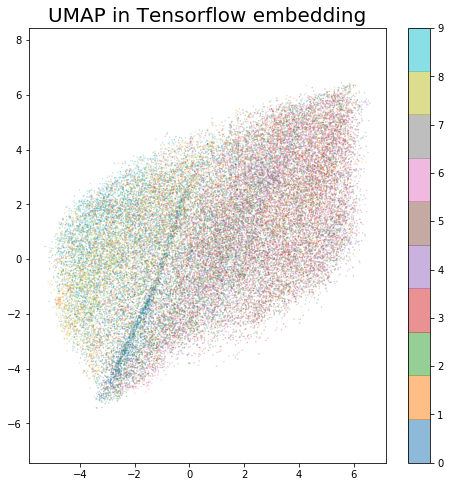

In [12]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.flatten(),
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [13]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [14]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

['umap_loss', 'recon_loss']
['recon_loss']


,wall_time,step,val,group,variable
0,1.594356e+09,1,4.999128,train,umap_loss
1,1.594356e+09,2,3.821824,train,umap_loss
2,1.594356e+09,3,3.108897,train,umap_loss


In [15]:
loss_df.group.unique()

array(['train', 'valid'], dtype=object)

Text(0.5, 1.0, 'Reconstruction loss')

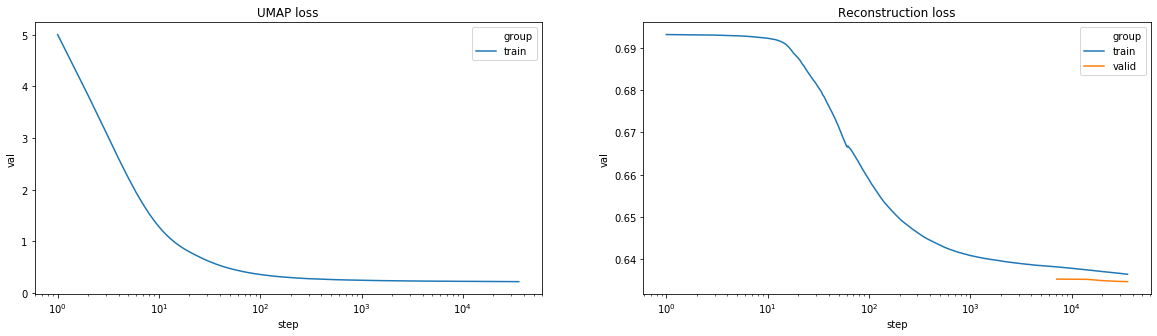

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5))
ax = axs[0]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'], ax = ax)
ax.set_xscale('log')
ax.set_title('UMAP loss')

ax = axs[1]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='recon_loss'], ax = ax)
ax.set_xscale('log')
ax.set_title('Reconstruction loss')

### Save output

In [17]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [18]:
output_dir = MODEL_DIR/'projections'/ 'cifar10' / 'autoencoder'
ensure_dir(output_dir)

In [19]:
embedder.save(output_dir)

Pickle of model saved


W0709 22:21:15.961861 140691818301248 deprecation.py:506] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
I0709 22:21:16.172884 140691818301248 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cifar10/autoencoder/encoder/assets


Encoder Keras model saved


I0709 22:21:16.798891 140691818301248 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cifar10/autoencoder/decoder/assets


Decoder Keras model saved


In [20]:
loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [21]:
np.save(output_dir / 'z.npy', z)

### Compare to direct embedding with base UMAP

In [22]:
from umap import UMAP

In [23]:
z_umap = UMAP(verbose=True).fit_transform(X_train_flat)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Thu Jul  9 22:21:17 2020 Finding Nearest Neighbors
Thu Jul  9 22:21:17 2020 Building RP forest with 15 trees
Thu Jul  9 22:21:19 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
Thu Jul  9 22:21:22 2020 Finished Nearest Neighbor Search
Thu Jul  9 22:21:23 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Jul  9 22:21:49 2020 Finished embedding


In [24]:
### realign using procrustes 
from scipy.spatial import procrustes
z_align, z_umap_align, disparity = procrustes(z, z_umap)
print(disparity)

0.03617609730259075


In [25]:
Y_train.flatten()

array([6, 9, 9, ..., 6, 2, 8], dtype=uint8)

Text(0.5, 1.0, 'UMAP with UMAP-learn')

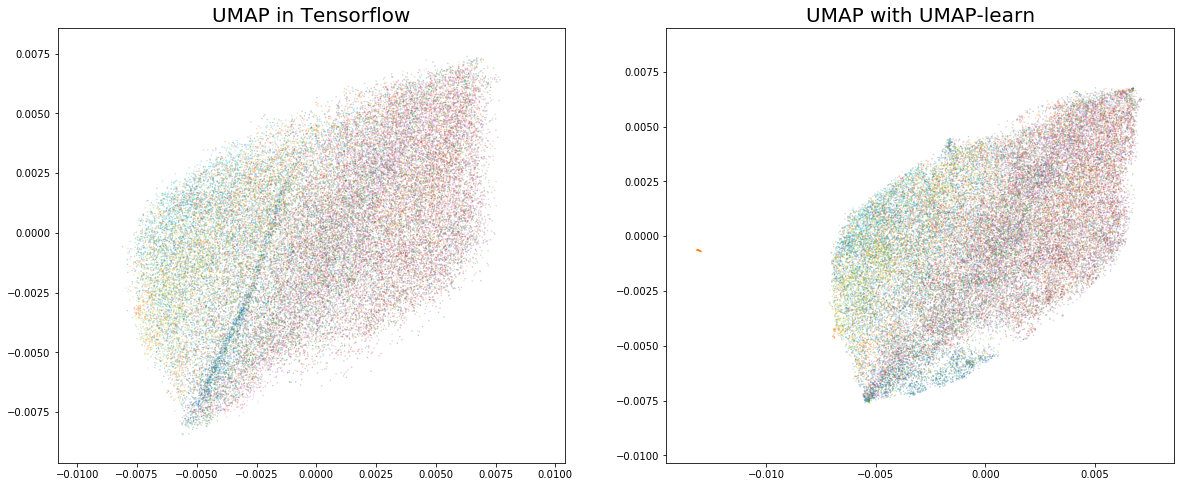

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
ax = axs[0]
sc = ax.scatter(
    z_align[:, 0],
    z_align[:, 1],
    c=Y_train.flatten(),
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow", fontsize=20)
#plt.colorbar(sc, ax=ax);

ax = axs[1]
sc = ax.scatter(
    z_umap_align[:, 0],
    z_umap_align[:, 1],
    c=Y_train.flatten(),
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP with UMAP-learn", fontsize=20)
#plt.colorbar(sc, ax=ax);

### View reconstructions on test data

In [27]:
z_test = embedder.transform(X_test)

In [28]:
X_test_recon = embedder.inverse_transform(z_test)

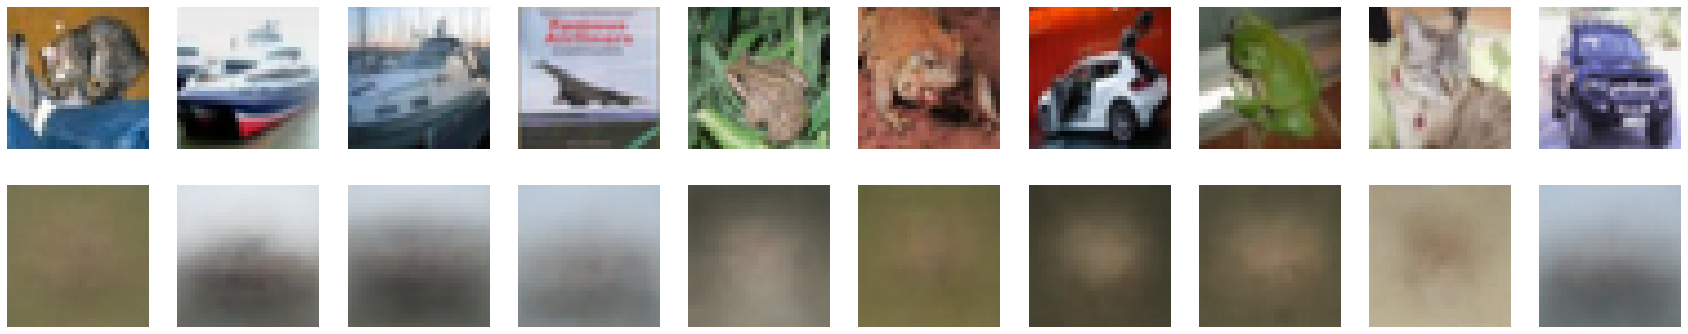

In [29]:
nex = 10
fig, axs = plt.subplots(ncols=nex, nrows=2, figsize=(3*nex,3*2))
for i in range(nex):
    axs[0,i].imshow(X_test[i].reshape(32,32,3))
    axs[1,i].imshow(X_test_recon[i].reshape(32,32,3))
for ax in axs.flatten():
    ax.axis('off')